## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [3]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [4]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the additive inflation for the dynamical and observation models

Define the time span of interest

In [5]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, tf/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [6]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [7]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

In [8]:
σx = 1e-2
σy = 1.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\boldsymbol{x}^i$ o generate i.i.d. samples from the system’s invariant (long-time) distribution, we sampleninitialconditions from a multivariate standard Gaussian distribution.  For each sample, we run the ODEin equation(SM.25)forT=  40,000steps using the Runge-Kutta method with a time-step of∆t= 0.01. The samples of the state at the final time are then i.i.d. samples from the push-forwarddistribution of the standard Gaussian through the nonlinear forward dynamics forTsteps

In [77]:
# Number of runs
Ne = 500

# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

Create cache to store the different final solutions

In [96]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [97]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(π0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    # Store the state
    X[Ny+1:Ny+Nx,i] .= deepcopy(sol.u[1])
end
# Apply the process noise
ϵx(X, Ny+1, Ny+Nx)
# Generate the observations
observe(h, X, tf, Ny, Nx)
# Apply the observation noise
ϵy(X, 1, Ny)

In [98]:
m = 30
S = HermiteMap(m, X; diag = true)

HermiteMap(30, 6, LinearTransform(6, [0.004140528765906998, -0.41790176419250796, 24.14932365820558, -0.5019477016583886, -0.9282383894978837, 23.624384361873847], [7.696246956189069 0.0 … 0.0 0.0; 0.0 8.62957523704247 … 0.0 0.0; … ; 0.0 0.0 … 8.625797947820805 0.0; 0.0 0.0 … 0.0 8.374779262487294], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [99]:
@time optimize(S, X, "kfolds"; withqr = true, verbose = false, hessprecond = false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


 30.385088 seconds (23.88 M allocations: 47.635 GiB, 10.27% gc time)


HermiteMap(30, 6, LinearTransform(6, [0.004140528765906998, -0.41790176419250796, 24.14932365820558, -0.5019477016583886, -0.9282383894978837, 23.624384361873847], [7.696246956189069 0.0 … 0.0 0.0; 0.0 8.62957523704247 … 0.0 0.0; … ; 0.0 0.0 … 8.625797947820805 0.0; 0.0 0.0 … 0.0 8.374779262487294], true), MapComponent[Map component of dimension 1 with Nψ 18 active features
, Map component of dimension 2 with Nψ 19 active features
, Map component of dimension 3 with Nψ 19 active features
, Map component of dimension 4 with Nψ 18 active features
, Map component of dimension 5 with Nψ 19 active features
, Map component of dimension 6 with Nψ 19 active features
])

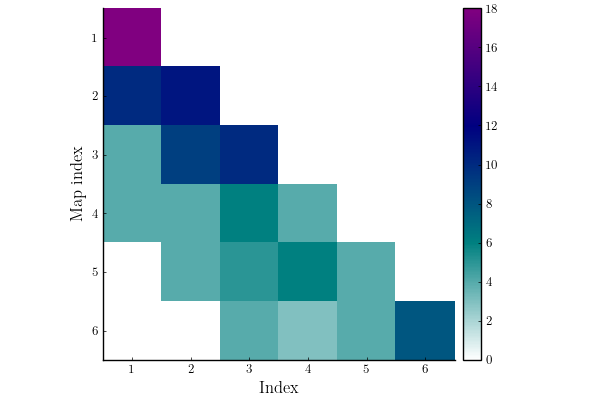

In [100]:
plot(S)

In [101]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
 2.12384e10  4.83877e7   1.10294e5   1.69948e10  0.0         0.0
 4.83877e7   2.491e10    2.36651e6   3.85832e5   2.36706e10  0.0
 1.10294e5   2.36651e6   1.94903e10  2.79324e5   4.41906e5   1.88305e10
 1.69948e10  3.85832e5   2.79324e5   1.70338e10  7.09918e5   1.31554e5
 0.0         2.36706e10  4.41906e5   7.09918e5   2.43177e10  5.77135e5
 0.0         0.0         1.88305e10  1.31554e5   5.77135e5   1.93091e10

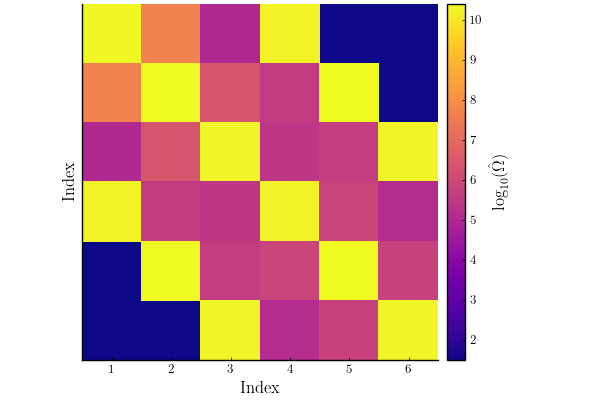

In [102]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

In [103]:
smf = StochMapFilter(x->x, ϵy, deepcopy(S), Ny, Nx, Δtdyn, Δtobs, 2*Δtobs, false)

Stochastic Map Filter with filtered = false


In [104]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

Set initial condition of the true system

In [105]:
x0 = rand(model.π0);

In [106]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [112]:
Ne = 300 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×300 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
  0.450853  -1.15917    1.9514    …   0.353231   -0.0516761  -1.49287
  0.256934  -0.792302  -0.177907     -0.0127671   0.132153   -0.992929
 -1.11143   -0.781188  -0.492358     -2.09601     0.667204   -1.94246

In [113]:
Xsmf = seqassim(F, data, 200, model.ϵx, smf, deepcopy(X), model.Ny, model.Nx, t0);

t = 0.1
getcoeff(M[6]) = [22.906865689731593, -19.377717740394523, 10.573024727789972, -9.986484533334767, 3.789827849345462, -5.217265100003962, -14.799818180191068, 11.06966570625046, 5.104130804711312, -9.019431424029612, 8.458281825773383, -4.806407518503932, -6.787279698165868, 0.5787759515689187, -5.161107934580359, 7.957617637274662, 3.275835920925548, -1.6247206443015998, 0.5633631184716991]
t = 0.2
getcoeff(M[6]) = [17.85023078671892, -11.000248348440945, 5.1987108032508935, -10.629238604398909, 1.7875722195231427, -5.687282299529215, -12.604635247248655, 11.85103933908719, 0.3937244075759413, -8.110224791605425, 10.264114923199173, -0.3859148017272309, -5.712876954409625, 0.2707366875331302, -5.667536310421616, 8.180916001757126, 6.303170658169496, -2.3939506752611965, 2.4915031788578834]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 0.30000000000000004
getcoeff(M[6]) = [11.266448824556152, 1.7164665570652637, 5.493215062828817, 3.492243552104856, -11.534891827906172, 0.40325664305245545, -10.578332655904953, -0.9692287045962255, -14.641361586766186, 1.6375096614555713, 4.498063811610749, -3.2666620550642813, -14.66832552870519, -2.0007712886552236, -6.24453941249212, -0.21700402237023336, 2.3343918353338977, -0.2464175487336985]
t = 0.4
getcoeff(M[6]) = [-12.021032884579379, 2.5879410077941563, -6.956304912161971, 1.404471658379549, 12.132333272675098, 2.4410590391182008, 7.50348577573972, 2.976039830233105, 4.343685759901692, -2.302041053411168, 0.549313380743777, 2.5024609093542183, 1.4612213537601701, 0.7007610900604446, 0.24583252057363303, -0.31533330637169915, -0.2329174466353028, -0.10016006147422259]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 0.5
getcoeff(M[6]) = [1.4812111545232898, -20.57274116122881, -1.2913346076302197, 6.047350903729115, -0.337767226969654, 2.127036820875832, -4.906151978010623, 4.602846602378159, 0.40760652593624125, 1.6580088144440814, 0.41541177913674, -4.173677299682894, 36.26542490030028, -0.19414544215102456, 2.7953778637267717, 13.848169504097127, -1.8079957931143913, -0.4305622856066912, 0.8803636490258625]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 0.6000000000000001
getcoeff(M[6]) = [-35.463927338316736, -9.50059874176015, -11.805736500765521, -1.4874680158739193, 1.1528544680000143, 1.7743306672364583, 6.862852603328631, 4.759929812548403, 2.1512600596491107, 1.6652046925407153, 2.281774371535699, 5.770252318162928, 9.67558338671935, 0.22386177695056067, 17.2752240539691, 8.721888247810433, 2.6145679834708178, 0.14284458484006124, 8.413548082746063]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 0.7000000000000001
getcoeff(M[6]) = [36.83276159205395, -24.951402390235423, 19.16806103593491, -13.51548058999118, 12.317189233360166, -8.382196278455845, -2.2999871675807455, 0.2850141031090243, -0.6673083064168583, -0.13501825269556278, -0.7396320810557167, -6.298258634467871, 17.461501486017063, 0.3504164233661924, -28.808657059272594, 7.627907065985614, 0.030494024287174293, -0.29947724884946014, -12.42370599360083]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 0.8
getcoeff(M[6]) = [4.565433754241828, 2.3294224479770222, -1.8633564627089911, -2.401907068813655, -2.8168366845668156, -2.015384250214061, 0.46498936314223244, -8.381394538274686, -2.2467048192599233, -3.1381345824189397, -2.0508705575482478, 0.7932128865144152, -8.076394028860504, -0.7333633198845051, 1.4108620580107984, 6.903021746153281, 0.4359847200774525, -0.6869085780471993, 0.6019815130458351]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 0.9
getcoeff(M[6]) = [0.10479994620853317, 2.0405092283807296, 2.139577749161759, -11.218773917595936, -6.1992102404451614, 2.112253510249005, 1.3402048390508912, 1.2076840207402293, 10.820803728091597, 9.190205065015583, 5.7866667931292755, 7.773620488345616, -3.967981022146112, -2.562361983118858, 0.6050288957650488, -0.15180562362082362, 1.5687059669549537, 2.1136114479741113, 0.6123826601023]
t = 1.0
getcoeff(M[6]) = [-6.04324140088469, -4.253811249057945, -3.1948133209383247, 2.596607139912836, -1.9021480871798437, -5.118104218906908, -1.0545580574863993, -2.3343850599312503, 2.4399889880769643, 3.9723476806112488, 2.754664312552088, 3.4434424515340374, 0.8150531876189495, -1.8064214492069208, 0.9398983863741891, -0.3488234493780035, 1.741653963014106, 1.2162823299090404, 0.15398714732793878]
t = 1.1
getcoeff(M[6]) = [-5.031263233609694, -9.273743995191236, -1.580877567316259, 6.973842266985953, -1.516497258783924, -7.11732744351757, -0.9813977394543284, -2.1794474913818793, -

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 1.7000000000000002
getcoeff(M[6]) = [16.240779734894538, 2.753274737696811, 11.127393193894278, 5.404941785584658, 4.454684914563776, 2.208678055259212, -4.904501157643727, -0.5711720428478302, -9.510699325816615, 0.23577656212377193, -3.37619342551989, 0.5058630987082465, -1.0511347354982659, 0.508218464725001, 0.6407263832415041, -0.24312841739799934, -0.6663669614003553, 0.4652505753543059, -1.636739117103299]
t = 1.8
getcoeff(M[6]) = [15.81106741790238, 1.7081342732414893, 9.707773419502708, -0.20920059484824952, 2.5053054079141126, -0.10967308154310834, -2.2423424765492186, -0.5698653184319518, -0.7875799008872055, -0.4802464265480154, -0.2624637785951831, -0.2720778956882433, -12.543345774321057, -2.3825058517936477, 0.6366551813603458, -0.2122727261428163, -5.215718873384914, -2.807802859688789, -0.614468152187268]
t = 1.9000000000000001
getcoeff(M[6]) = [-0.7142979739344772, 1.9427317760694047, -3.0567942037186806, 2.738588534230587, -0.30187646579803873, 1.2742731175995052

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 3.3000000000000003
getcoeff(M[6]) = [-6.085900633339495, 4.080932378975479, -4.5314921976379745, -6.651111340251221, 0.3931226950206943, 15.688898938822392, -4.356015553839515, 10.380928274573629, -5.025293516846164, 7.041750819063172, 2.224872185923541, -3.6837171803065196, 0.6489313218799471, -1.5627542332708342, 2.081082311512999, -1.3484115947775916, -3.956068684651415, 0.8401606230353779, -1.4772026383680372]
t = 3.4000000000000004
getcoeff(M[6]) = [-1.7952107146621756, 1.3554786403100758, -0.7549462391861967, -2.6624092439004543, 0.1293686804564897, 7.127284906960041, -4.137949644751515, 7.739264419055421, -8.062031921630892, 7.088482777070861, 0.7820077119855762, -0.38731024071205405, 0.06493214434037048, -4.15236210633801, 3.1485719640823993, 0.24747229615245994, -1.5294661167570611, 1.1067761511256464, -0.11753842692947533]
t = 3.5
getcoeff(M[6]) = [-21.18835519886454, 3.919163051935475, -9.166959777082706, -3.8545305696952026, -0.11009430412715424, 8.4992398257696, -4.080

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 3.6
getcoeff(M[6]) = [10.961568288334483, 4.608501878853842, 2.5649160201387384, 1.3971940185094347, -0.3954017243731065, 8.84809973486096, -1.9901458060212531, 4.672924326843006, -1.5617457287523717, 2.422698741957526, 2.5586856864751786, 1.2460405061085247, 0.0008791667248767565, 0.3430571448412561, 1.3136152612344814, 0.13322829224162325, -22.89583614456241, 0.5943241365996197, -9.358645197877797]
t = 3.7
getcoeff(M[6]) = [6.888864014406584, 7.16110175626948, 2.508261580866249, 8.860465565459986, -0.850568388627718, -0.6535050317555609, -2.045480885412453, -1.0251196497735542, -2.3712982582437783, -0.7111834908697166, 2.8979246935431413, 4.457003590356256, -1.0151589542912796, -0.35599428931672006, 0.052372175931808096, 1.338793242300031, -14.79575092808284, -4.660899153516263, -5.160846716437222]
t = 3.8000000000000003
getcoeff(M[6]) = [-3.3679745765970592, 6.088977554581177, -3.62414731561908, -14.55734009655886, 0.00526800883508477, 4.934767814525912, -2.750087481477597, 4.48

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 5.1000000000000005
getcoeff(M[6]) = [-2.635115604617946, 3.259383219670261, -0.7726539703696274, 2.169534025925637, 0.06400892422531496, -1.9736579465384076, -4.755803829147008, -1.8884093967630768, -4.451670380827411, -2.1468151924882015, 1.1773959315194076, 0.17322884887640233, 0.060355314396875304, -1.1557106428986714, -0.797579919152261, -0.4372877662773053, 1.991369233726076, 0.8895944188683297, 0.5130631671910988]
t = 5.2
getcoeff(M[6]) = [0.6109979746617218, 3.215449767544893, -0.0016929158449054422, -2.0384014927486427, 0.42363287221275403, 0.3353357116988644, -2.900860461349117, 6.462709956886907, -4.577061176682111, 10.594785478467323, 0.4250341251616511, -1.6439759943310168, 0.39367206936232035, -1.5785797309529803, 5.834644794807058, -0.5452378785772948, 2.0336836908352445, 2.9492036156676957, 0.9255195700775186]
t = 5.300000000000001
getcoeff(M[6]) = [-4.8243968837914455, 1.3997876294061604, -6.063055614303279, -11.998225065836042, -0.2817661243384635, 14.3933221994221

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 5.7
getcoeff(M[6]) = [-14.015622618442134, 9.017571567447671, -4.2104808445376, 1.836602472351366, 0.13518697938135144, -2.3417147055512055, -5.618722590171722, -0.7608571165766809, -5.360488976892056, -1.125013296317668, 4.1999305987357065, 1.4499119929740738, -0.0757071547006126, -1.9837963988627012, -1.6541603916776328, 0.9820395960334811, 13.651263523530766, 3.2773242590133727, 3.0044361451489325]
t = 5.800000000000001
getcoeff(M[6]) = [0.9072631635692265, 1.9472864826755578, -0.2569026808466893, -2.353711531533257, -0.6601680060127978, -1.509025709308327, -3.815146966013972, -0.17333016724908656, -5.309099386227708, 0.4567385759032456, 0.9207513500423667, -0.6810856757308157, -0.6081442773447763, -2.0307800102104867, 0.27324311016701075, 0.500920793566277, 3.032432411337262, -0.4026983189172326, 1.618807702693217]
t = 5.9
getcoeff(M[6]) = [4.370833395088064, 2.986902476877143, 2.1498134847771184, 6.499780640599392, 0.7220216216165163, -6.323885029414955, -5.562385495127881, -2

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 6.300000000000001
getcoeff(M[6]) = [-3.997413711771021, 13.4807834141093, -1.3813152163957072, 6.22140991619135, 1.1621333677923456, -8.5730850049266, -5.053973969844967, -6.795308275366555, -2.9224001898545366, -6.292217632106094, 5.812708625833964, 3.995539098160839, 1.4621358302172784, 0.6680834155462363, -2.6857215708024214, 1.4775350171181658, 5.682555089268931, 8.580931944023101, 1.90403200872905]
t = 6.4
getcoeff(M[6]) = [-0.5917967643434459, 2.496610703183193, 0.007426761394741327, -0.5798178512842624, -0.2566079368325596, 3.844179455195965, -4.166242528270152, 2.820079299554281, -4.969768163085823, 2.0173569211226483, 1.6170039365838942, 0.3475629751045034, 0.011760898560819563, -2.1128669216556073, 0.9911854398881061, 0.7181230670982183, -2.106852141072374, -0.40404640522007745, -0.6467892777544653]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 6.5
getcoeff(M[6]) = [7.9403032652571195, -2.2628501799739853, -22.49298075267149, 2.6724202867989297, 14.198685947225986, 2.4732931101221327, -14.680752088511374, 2.910951642186377, 2.986462366132087, -1.117320438003481, -9.603000126171263, 6.788870400919036, 0.27643505198057183, 1.8342599991543032, 0.6467246791665586, -0.3552340449971332, -0.023474328549795795, -3.1934002733061524, -0.41617045105275546]
t = 6.6000000000000005
getcoeff(M[6]) = [-8.87524180931102, 0.036594813108350374, 16.411360900752094, 1.3022095363477755, -6.814397914417603, 0.7926539032716039, 10.320323887585838, 2.7162233346800027, -2.545272579040214, 0.08096028348957822, 4.984110741940566, -3.8314718900317173, -0.8310778105261747, -1.6299945140836487, 1.6357592141735389, -0.012705447656636221, 0.16106280594830605, 0.9694030094903481, -0.3364862070455417]
t = 6.7
getcoeff(M[6]) = [-21.118619386949543, 0.6785681857442867, 18.653635741847193, -0.14252549946236723, 4.579812963405576, 1.8800305401130446, 11.850510

t = 8.5
getcoeff(M[6]) = [5.058104764553865, 6.126442975956429, -12.224218467590408, 0.39023843257021523, 7.7170892879970765, 6.142396531805749, -3.614055849237954, 1.3477270138062372, 1.7591990903259347, 3.023030343003145, 4.065305111457187, 5.472304112950203, 4.52031846241044, 2.106914333561585, 0.988438148071948, 0.10627097650109582, -0.03204783131829077, 4.046506177182476, 1.4353328531222205]
t = 8.6
getcoeff(M[6]) = [6.141677114131798, -1.5672981860205537, -27.422298568116286, -0.7063143237365509, 21.074439084368034, 2.07284891493673, -14.569208527967355, -1.1606161226372416, 0.7790004939811674, -0.7646028478635787, -5.240452333381095, 10.013400778114518, 1.4265278717913716, 1.961169381919871, 0.2655197261204615, -0.33186320887268017, -0.09832234338217959, -0.5634420080698823, 1.5491215481657126]
t = 8.700000000000001
getcoeff(M[6]) = [46.14992191555025, 9.927098137518659, -0.5023440535306471, -3.0605779003951916, -47.59100807342954, 12.836787213460992, 0.35866373131512896, -6.335

t = 10.600000000000001
getcoeff(M[6]) = [-1.5216910389516602, 0.6402262595312243, 0.7944489361018616, 1.678777695781111, 1.446354658433854, 0.8908024131180967, 3.961806271164352, 4.020897551764961, -0.5416427778273949, 0.3061247825810473, 6.099435899248736, -0.6790109635799078, 1.5490566066117148, -0.6535352709973022, 2.9691460371053715, -0.47498730354944924, 0.11673409680774652, 3.3767022193249105, 0.5110521094860654]
t = 10.700000000000001
getcoeff(M[6]) = [2.418574442212733, 0.4121443545035912, -6.261551515373374, 0.9086379147858681, 3.38429052581146, 0.2609987058822719, -5.348686702765683, 1.5126346444617464, 1.106819176517067, -0.13620309224896776, -3.7579143886782447, 1.5882798409935093, -0.10838743731283257, 0.5898502787579502, 0.5968476487537444, 0.009099069522303096, 0.2867799176699296, -1.6594691316754762, -0.4845385217842395]
t = 10.8
getcoeff(M[6]) = [2.071206113903167, 3.5228019932331804, -1.9921376234988157, 0.6048091041361059, -0.24456008706290078, 3.324630293646372, -5.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 11.8
getcoeff(M[6]) = [-5.469519285820407, 2.0990819335115782, 7.857766210788713, -1.7279760809094287, -4.766883280162924, 3.0602969983111654, -6.573392824153872, -3.6016545884782674, -1.578137299618098, -0.0298593402027102, -14.760818677431725, -2.17086229165443, 4.200096145891642, -0.20522610679691633, -2.023619116057716, 0.3272579692805943, 0.00834364200686141, -6.759277526160492, 1.960310322721944]
t = 11.9
getcoeff(M[6]) = [-9.845042457856723, 3.6038207310495016, 6.75394365981151, 0.8611735354022676, 5.9072805550168015, 5.3791385077533, 13.088394971435763, 1.740389641153707, -1.8385458725665977, 0.9818433211249874, 17.72388599702033, 3.311576267396134, 3.585078687713686, 1.1300265267004956, 1.5981052664094952, 0.08570721896558871, -0.007072316696698734, 8.761531396005477, 0.5764527521278098]
t = 12.0
getcoeff(M[6]) = [-7.985083828552651, 6.033765430922351, 5.53711812529081, -0.1279589529319527, 4.5102923212561015, 5.03192380824692, 9.42176129148425, -0.1778350014143839, -1.728

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


t = 12.9
getcoeff(M[6]) = [0.015507768028422185]
t = 13.0
getcoeff(M[6]) = [-0.06433896732776337]
t = 13.100000000000001
getcoeff(M[6]) = [-0.07504839075399962]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 13.200000000000001
getcoeff(M[6]) = [-0.2560454382918119]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 13.3
getcoeff(M[6]) = [-0.22769392513153408]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 13.4
getcoeff(M[6]) = [0.11447033909749113]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 13.5
getcoeff(M[6]) = [-0.12245418722883814]
t = 13.600000000000001
getcoeff(M[6]) = [-0.1579597576069962]
t = 13.700000000000001
getcoeff(M[6]) = [-0.007187243676312373]
t = 13.8
getcoeff(M[6]) = [0.182379148998432]
t = 13.9
getcoeff(M[6]) = [0.0681924723314449]
t = 14.0
getcoeff(M[6]) = [0.26391015966549747]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.100000000000001
getcoeff(M[6]) = [0.24853319031114665]
t = 14.200000000000001
getcoeff(M[6]) = [0.19252302083832357]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.3
getcoeff(M[6]) = [0.16130121006735132]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.4
getcoeff(M[6]) = [0.18120181444820613]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.5
getcoeff(M[6]) = [0.20327402093426047]
t = 14.600000000000001
getcoeff(M[6]) = [0.04505377193428239]
t = 14.700000000000001
getcoeff(M[6]) = [0.18048924119462198]
t = 14.8
getcoeff(M[6]) = [0.03505375805664303]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.9
getcoeff(M[6]) = [0.18981993449138312]
t = 15.0
getcoeff(M[6]) = [-0.022093190483478912]
t = 15.100000000000001
getcoeff(M[6]) = [0.1536077312282225]
t = 15.200000000000001
getcoeff(M[6]) = [0.2563655195022619]
t = 15.3
getcoeff(M[6]) = [0.06808090346784205]
t = 15.4
getcoeff(M[6]) = [0.19268178144530337]
t = 15.5
getcoeff(M[6]) = [0.2056458905798536]
t = 15.600000000000001
getcoeff(M[6]) = [0.07146135650460914]
t = 15.700000000000001
getcoeff(M[6]) = [-0.09674794932419967]
t = 15.8
getcoeff(M[6]) = [0.30421145014957857]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 15.9
getcoeff(M[6]) = [0.22556689520883438]
t = 16.0
getcoeff(M[6]) = [0.177810655225012]
t = 16.1
getcoeff(M[6]) = [0.2289170919078708]
t = 16.2
getcoeff(M[6]) = [0.10380197328905831]
t = 16.3
getcoeff(M[6]) = [0.010732700162961399]
t = 16.400000000000002
getcoeff(M[6]) = [0.004013512051487619]
t = 16.5
getcoeff(M[6]) = [-0.020594609323276156]
t = 16.6
getcoeff(M[6]) = [-0.04038102252352508]
t = 16.7
getcoeff(M[6]) = [0.016993814227484003]
t = 16.8
getcoeff(M[6]) = [0.21655573324549762]
t = 16.900000000000002
getcoeff(M[6]) = [-0.02041031858811846]
t = 17.0
getcoeff(M[6]) = [0.04240505184889182]
t = 17.1
getcoeff(M[6]) = [0.05215606628445934]
t = 17.2
getcoeff(M[6]) = [0.187120493145923]
t = 17.3
getcoeff(M[6]) = [0.08330618451935878]
t = 17.400000000000002
getcoeff(M[6]) = [-0.08551610678840273]


┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/mat/.julia/packages/LineSearches/Ki4c5/src/hagerzhang.jl:148
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 17.5
getcoeff(M[6]) = [-0.13707023868676185]
t = 17.6
getcoeff(M[6]) = [-0.09872105461004223]
t = 17.7
getcoeff(M[6]) = [0.20294750459887811]
t = 17.8
getcoeff(M[6]) = [0.37475422883878984]
t = 17.900000000000002
getcoeff(M[6]) = [0.2264373838094163]
t = 18.0
getcoeff(M[6]) = [0.19212117390763886]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 18.1
getcoeff(M[6]) = [0.11092093336325369]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 18.2
getcoeff(M[6]) = [0.125782576252524]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 18.3
getcoeff(M[6]) = [0.11763114198743012]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 18.400000000000002
getcoeff(M[6]) = [0.31926556871215966]
t = 18.5
getcoeff(M[6]) = [0.3197780872652429]
t = 18.6
getcoeff(M[6]) = [0.3206146642245898]
t = 18.7
getcoeff(M[6]) = [0.33855793619782665]
t = 18.8
getcoeff(M[6]) = [0.3132057133981457]
t = 18.900000000000002
getcoeff(M[6]) = [0.2449356772299164]
t = 19.0
getcoeff(M[6]) = [0.3655208103360892]
t = 19.1
getcoeff(M[6]) = [0.33408286430235234]
t = 19.200000000000003
getcoeff(M[6]) = [0.310438919972776]
t = 19.3
getcoeff(M[6]) = [0.3251869430331806]
t = 19.400000000000002
getcoeff(M[6]) = [0.3126313624852118]
t = 19.5
getcoeff(M[6]) = [0.2831918162294246]
t = 19.6
getcoeff(M[6]) = [0.2894385624122402]
t = 19.700000000000003
getcoeff(M[6]) = [0.20853863638772574]
t = 19.8
getcoeff(M[6]) = [0.2854615206716034]
t = 19.900000000000002
getcoeff(M[6]) = [0.2364396235017641]
t = 20.0
getcoeff(M[6]) = [0.2928453460702]


In [114]:
data.xt

3×1000 Array{Float64,2}:
 -0.658908  -2.31204   -7.45684  -18.3202  …   5.65985  11.5922  15.3166
 -1.59451   -5.10262  -15.7835   -27.5539     10.0042   18.5109  13.1053
 -0.740262  -0.153      4.19991   31.4612     12.688    20.9545  38.3418

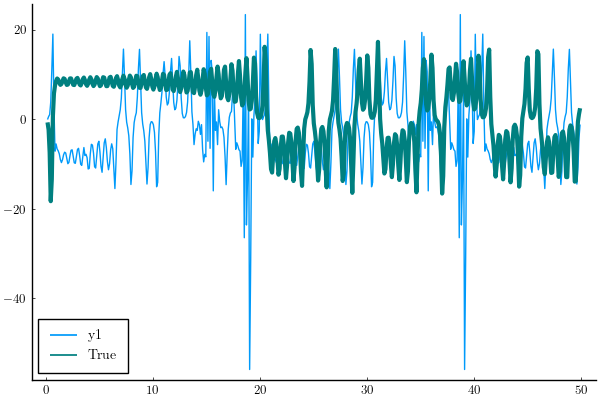

In [115]:
plot(data.tt[nb:Δ:ne], -mean_hist(Xsmf)[1,:])
plot!(data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")


In [94]:
# Plot the first component of the state over time
nb = 1
ne = 499
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "Stochastic Map Filter")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3×201 Array{Float64,2} at index [1, 2:1:500][39m

In [33]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.